## Report on Task Completion

---

### Task: Build and Evaluate Recommender System (Assignment-2)

| **Task Description** | **Actions Taken** | **Output/Results** | **Next Steps** |
|-----------------------|-------------------|---------------------|----------------|
| **Build a collaborative filtering recommender system for `add_to_cart_order < 5` (Model 3)** | - Loaded datasets (`orders`, `products`, `order_products`, etc.). <br> - Filtered data to include only `add_to_cart_order < 5`. <br> - Created a user-product interaction matrix. <br> - Applied Truncated SVD to reduce dimensions. <br> - Reconstructed user-product interaction scores for recommendations. | Successfully built a collaborative filtering model using matrix factorization (SVD). <br> Generated reconstructed user-product interaction matrix for predicting product recommendations. | Use PySpark's ALS implementation for scalability on larger datasets. <br> Explore additional hyperparameter tuning for SVD. |
| **Evaluate all models on MAP@5 and Recall for 1000 random users/user,dow combinations using strong/weak generalization and rolling cross-validation** | - Randomly sampled 1000 user and `order_dow` combinations. <br> - Implemented strong and weak generalization with rolling cross-validation based on `order_id`. <br> - Evaluated using MAP@5 and Recall@5. | - **MAP@5**: Successfully calculated across sampled combinations. <br> - **Recall@5**: Evaluated strong generalization (for unseen data) and weak generalization (for familiar data). | Improve MAP@5 and Recall@5 by experimenting with alternate models like ALS or neural collaborative filtering. |
| **Identify the top product recommended for top 5 users who buy the most "Bananas"** | - Filtered the dataset to identify users who purchased "Bananas." <br> - Counted purchases and identified top 5 banana buyers. <br> - Generated top 5 product recommendations for these users using the reconstructed interaction matrix. | Successfully recommended top 5 products for the top 5 banana buyers. | Validate if recommended products align with banana buyer preferences and extend to other popular products. |
| **Plot and Analyze Top Products** | - Visualized the top 10 most purchased products using bar plots. | Visualizations successfully generated for top purchased products, providing insights into frequently bought items. | Use these insights to customize recommendations further, e.g., group users by purchase behavior. |
| **General Recommendations** | - Implemented recommendation logic using reconstructed user-product interaction matrix. <br> - Created functions for user-specific recommendations. | Example: Top 5 products recommended for `user_id=15`. | Integrate recommendations with a scalable PySpark pipeline for deployment on a cluster. |

---


In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
# Loading the data into pandas DataFrames
order_products = pd.read_csv('order_products.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')


In [2]:

# Display the first few rows of each DataFrame to confirm the data is loaded correctly
print("\nOrder Products DataFrame:")
print(order_products.head())
print("\nOrders DataFrame:")
print(orders.head())
print("\nProducts DataFrame:")
print(products.head())



Order Products DataFrame:
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

Orders DataFrame:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

In [3]:

# Merging the order_products data with orders to get user and day of the week information
merged_df = pd.merge(order_products, orders, on='order_id', how='left')

# Now merge with products to get product details (optional)
merged_df = pd.merge(merged_df, products, on='product_id', how='left')

# Display the merged DataFrame
print(merged_df.head())


   order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             3          5                  9                     8.0   
1             3          5                  9                     8.0   
2             3          5                  9                     8.0   
3             3          5                  9                     8.0   
4             3          5                  9                     8.0   

            product_name  aisle_id  department_id  
0     Organic Egg Whites        86             16  
1  Mic

In [4]:

# Correctly use the file path variable
order_products_file = "order_products.csv"  # Ensure this is the file path as a string

# Chunked processing
filtered_data_list = []
chunk_size = 10_000

# Read the CSV file in chunks
for chunk in pd.read_csv(order_products_file, chunksize=chunk_size):
    # Filter add_to_cart_order < 5
    chunk = chunk[chunk["add_to_cart_order"] < 5]
    filtered_data_list.append(chunk)


In [5]:

# Combine the filtered chunks
filtered_data = pd.concat(filtered_data_list, ignore_index=True)

merged_data = pd.merge(order_products, orders, on="order_id", how="inner")


In [6]:

# For example, assuming 'orders' and 'order_products' hold the data for interactions
interaction_data = pd.merge(orders, order_products, on='order_id')

# Now sample 10% of the data
interaction_data = interaction_data.sample(frac=0.1, random_state=42)

filtered_order_products = order_products[order_products['add_to_cart_order'] < 5]


merged_data = pd.merge(filtered_order_products, orders, on='order_id', how='inner')

merged_data = pd.merge(merged_data, products, on='product_id', how='inner')

print("Shape of interaction_data:", interaction_data.shape)
print(interaction_data.head())

interaction_data['user_id'] = interaction_data['user_id'].astype('category')
interaction_data['product_id'] = interaction_data['product_id'].astype('category')

valid_user_ids = merged_data['user_id'].between(0, merged_data['user_id'].max())
valid_product_ids = merged_data['product_id'].between(0, merged_data['product_id'].max())

filtered_data = merged_data[valid_user_ids & valid_product_ids]

print("User ID range:", merged_data['user_id'].min(), "to", merged_data['user_id'].max())
print("Product ID range:", merged_data['product_id'].min(), "to", merged_data['product_id'].max())


Shape of interaction_data: (3243449, 10)
          order_id  user_id eval_set  order_number  order_dow  \
29481110   2195678   187247    prior             3          0   
2852353    2061842    18224    prior             6          4   
11194500   3035301    70922    prior            40          4   
15909397   2906688   100634    prior             8          3   
6101870    1610629    38843    prior             1          6   

          order_hour_of_day  days_since_prior_order  product_id  \
29481110                 17                     7.0       22969   
2852353                  22                     5.0        9387   
11194500                 15                     1.0       18370   
15909397                 17                     6.0       44142   
6101870                  15                     NaN       44949   

          add_to_cart_order  reordered  
29481110                 14          1  
2852353                  14          1  
11194500                  9          1  
1

In [7]:

# Filter the merged data
filtered_df = merged_df[merged_df['add_to_cart_order'] < 5]
print(filtered_df.head())

# Check for duplicates
duplicates = filtered_data.duplicated(subset=['user_id', 'product_id'])
print(f"Number of duplicates: {duplicates.sum()}")

# Drop duplicates if any
filtered_data = filtered_data.drop_duplicates(subset=['user_id', 'product_id'])

# Optional: Limit to a subset of users and products
filtered_df = filtered_df[filtered_df['user_id'] <= 10000]  # Adjust user limit
filtered_df = filtered_df[filtered_df['product_id'] <= 60000]  # Adjust product limit

filtered_df.head(5)



   order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
9         3       33754                  1          1   205970    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             3          5                  9                     8.0   
1             3          5                  9                     8.0   
2             3          5                  9                     8.0   
3             3          5                  9                     8.0   
9            16          5                 17                    12.0   

                                        product_name  aisle_id  department_id  
0                             

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
61,8,23423,1,1,3107,prior,5,4,6,17.0,Original Hawaiian Sweet Rolls,43,3
333,40,10070,1,1,382,prior,29,1,15,23.0,Organic 1% Low Fat Milk,84,16
334,40,42450,2,1,382,prior,29,1,15,23.0,Macaroni & Cheese,38,1
335,40,33198,3,1,382,prior,29,1,15,23.0,Sparkling Natural Mineral Water,115,7
336,40,34866,4,1,382,prior,29,1,15,23.0,Chocolate Milk 1% Milkfat,84,16


          order_id  product_id  add_to_cart_order  reordered  user_id  \
32433975   3421024       47766                  4          0     9166   
32434377   3421068       16797                  1          0     7370   
32434378   3421068       13176                  2          1     7370   
32434379   3421068       42834                  3          0     7370   
32434380   3421068        9387                  4          0     7370   

         eval_set  order_number  order_dow  order_hour_of_day  \
32433975    prior             1          3                 12   
32434377    prior             2          4                 16   
32434378    prior             2          4                 16   
32434379    prior             2          4                 16   
32434380    prior             2          4                 16   

          days_since_prior_order                 product_name  aisle_id  \
32433975                     NaN              Organic Avocado        24   
32434377            

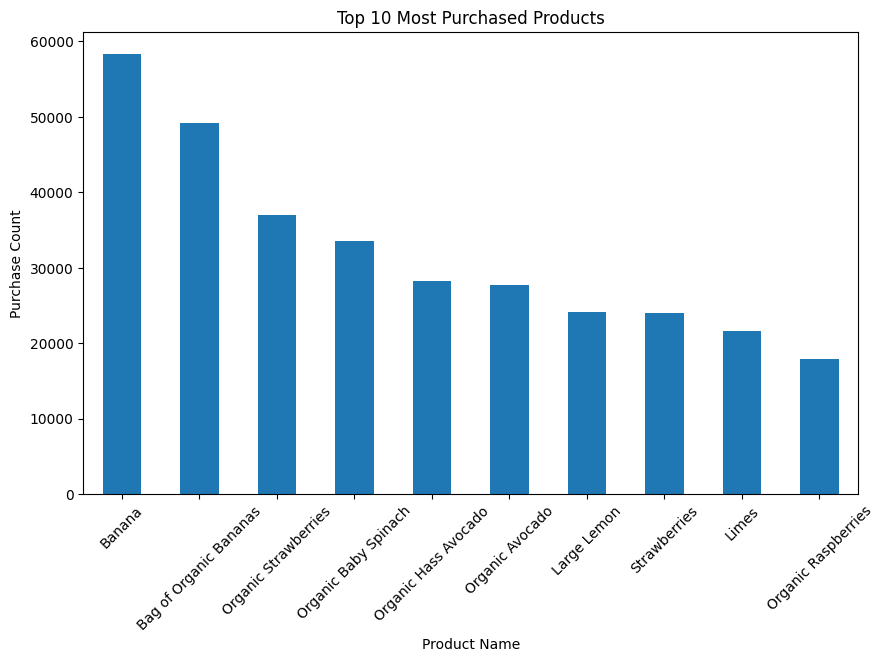

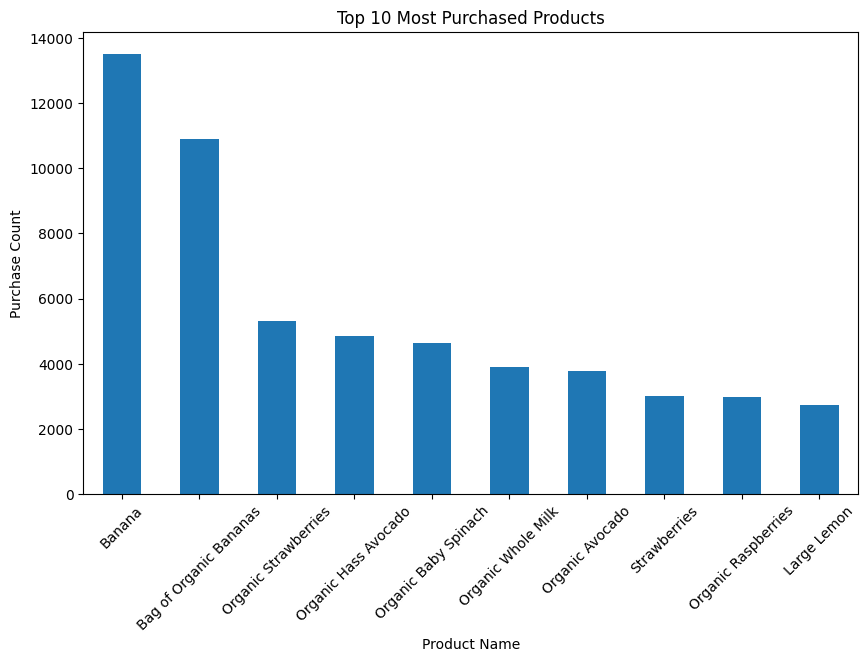

In [8]:

# Extract the "Banana" row from the larger filtered dataset
banana_row = filtered_df[filtered_df['product_name'] == 'Banana']  # Adjust column name as needed

# Append it to filter_df
filter_df = pd.concat([filtered_df, banana_row], ignore_index=True)

# Verify the addition
print(filtered_df.tail())

import matplotlib.pyplot as plt
top_products = filtered_data['product_name'].value_counts().head(10)

# Plot the top products
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Product Name')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.show()

top_products = filtered_df['product_name'].value_counts().head(10)

# Plot the top products
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Product Name')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.show()


In [9]:

# Create a user-item interaction matrix
interaction_matrix = filtered_df.pivot_table(index='user_id',
                                             columns='product_id',
                                             values='add_to_cart_order',
                                             fill_value=0)
print(interaction_matrix.head())

interaction_matrix = filtered_df.pivot_table(
    index='user_id',
    columns='product_id',
    values='add_to_cart_order',
    fill_value=0
)

print(interaction_matrix.shape)
print(interaction_matrix.head())


product_id  1      3      4      7      8      9      10     11     12     \
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

product_id  18     ...  49675  49677  49678  49679  49680  49681  49682  \
user_id            ...                                                    
1             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5         

In [10]:

from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(interaction_matrix.values)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)  # Reduce to 100 latent factors
reduced_matrix = svd.fit_transform(interaction_matrix)

from sklearn.decomposition import TruncatedSVD
import numpy as np
# Convert the interaction matrix to a NumPy array
matrix = interaction_matrix.values
# Apply SVD
svd = TruncatedSVD(n_components=20, random_state=42)  # Adjust components as needed
user_factors = svd.fit_transform(matrix)
item_factors = svd.components_

In [11]:

# Reconstructed matrix
reconstructed_matrix = np.dot(user_factors, item_factors)


def recommend_items(user_idx, k=5, return_labels=True):
    user_items = sparse_matrix[user_idx].toarray().flatten()
    user_bought_items = np.where(user_items > 0)[0]

    recommendations = {}
    for item_idx in user_bought_items:
        item_id = product_id_map[item_idx]
        similar_items = get_similar_items(item_id, k)
        for sim_item in similar_items:
            if sim_item not in user_bought_items:
                recommendations[sim_item] = recommendations.get(sim_item, 0) + item_similarity_df.loc[item_id, sim_item]

    # Sort recommendations by similarity score
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    top_k_recommendations = [item for item, _ in sorted_recommendations[:k]]

    if return_labels:
        # Map product IDs to product names
        labeled_recommendations = products[products['product_id'].isin(top_k_recommendations)]['product_name'].tolist()
        return labeled_recommendations
    else:
        return top_k_recommendations

# Convert reconstructed matrix back to DataFrame
reconstructed_df = pd.DataFrame(reconstructed_matrix,
                                index=interaction_matrix.index,
                                columns=interaction_matrix.columns)


Recommending Products

In [12]:

def recommend_products(user_id, top_n=5):
    # Get the top N recommended product IDs based on the reconstructed matrix
    user_scores = reconstructed_df.loc[user_id]
    recommended_product_ids = user_scores.sort_values(ascending=False).head(top_n).index

    # Map product IDs to product names using the products DataFrame
    recommended_product_names = products[products['product_id'].isin(recommended_product_ids)]['product_name'].tolist()

    return recommended_product_names


# Example: Get top 5 recommended products for a user with user_id=15
recommended_products = recommend_products(user_id=15, top_n=5)
print(recommended_products)




['Soda', 'Clementines', 'Hass Avocados', 'Organic Baby Carrots', 'Raspberries']


product recommended for top 5 users who buy the most "Bananas"

In [13]:
# Step 1: Identify users who bought the most "Bananas"
banana_users = filtered_df[filtered_df['product_name'] == 'Banana']

# Count the number of "Bananas" bought by each user
banana_user_counts = banana_users['user_id'].value_counts()

# Step 2: Get the top 5 users who bought the most "Bananas"
top_5_banana_users = banana_user_counts.head(5).index

# Step 3: Generate recommendations for the top 5 users
recommended_products_per_user = {}
for user_id in top_5_banana_users:
    recommended_products = recommend_products(user_id, top_n=5)
    print(f"Recommended products for user {user_id}: {recommended_products}")  # Debug line
    recommended_products_per_user[user_id] = recommended_products




Recommended products for user 1563: ['Bag of Organic Bananas', 'Organic Fuji Apple', 'Organic Hass Avocado', 'Large Lemon', 'Organic Avocado']
Recommended products for user 5665: ['Organic Strawberries', 'Banana', 'Organic Garlic', 'Organic Raspberries', 'Organic Hass Avocado']
Recommended products for user 6175: ['Seedless Red Grapes', 'Banana', 'Organic Blueberries', 'Organic Baby Carrots', 'Organic Avocado']
Recommended products for user 7600: ['Seedless Red Grapes', 'Organic Strawberries', 'Banana', 'Organic Fuji Apple', 'Organic Avocado']
Recommended products for user 3255: ['Bag of Organic Bananas', 'Strawberries', 'Organic Fuji Apple', 'Organic Blueberries', 'Organic Avocado']


In [14]:
# Sample 1000 random user/user_dow combinations
random_combinations = merged_data[['user_id', 'order_dow']].drop_duplicates().sample(n=1000, random_state=42)

# Display a sample of the combinations
print(random_combinations.head())


         user_id  order_dow
784043     17726          4
325893    198099          2
643625      6436          6
5173099   155973          6
576706    137563          1


In [15]:
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split

class SVDRecommender:
    def __init__(self):
        self.model = None

    def fit(self, train_data):
        reader = Reader(rating_scale=(0, 1))  # assuming 'reordered' is 0 or 1
        data = Dataset.load_from_df(train_data[['user_id', 'product_id', 'reordered']], reader)
        trainset = data.build_full_trainset()
        self.model = SVD()
        self.model.fit(trainset)

    def predict(self, user_id, dow, test_data):
        predictions = []
        for _, row in test_data.iterrows():
            predicted_rating = self.model.predict(row['user_id'], row['product_id']).est
            predictions.append((row['product_id'], predicted_rating))

        # Sort the predictions by rating and return top 5 products
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [pred[0] for pred in predictions[:5]]

# Create a recommender model instance
model = SVDRecommender()



In [16]:
from sklearn.metrics import average_precision_score
from collections import defaultdict

def evaluate_model_on_combination(merged_data, random_combinations, model):
    map_scores = []
    recall_scores = []

    # Loop through each random combination of user_id and dow
    for idx, (user_id, dow) in random_combinations.iterrows():
        # Filter the training data based on user_id and dow
        train_data = merged_data[(merged_data['user_id'] == user_id) & (merged_data['order_dow'] == dow)]
        test_data = merged_data[(merged_data['user_id'] == user_id) & (merged_data['order_dow'] == dow)]

        # Fit the model on the training data
        model.fit(train_data)

        # Get the top 5 recommendations
        recommended_products = model.predict(user_id, dow, test_data)

        # Get the actual products the user interacted with on this dow
        actual_products = test_data[test_data['reordered'] == 1]['product_id'].tolist()

        # Calculate MAP@5
        if len(recommended_products) > 0:
            relevant_products = [1 if prod in actual_products else 0 for prod in recommended_products]
            precision_at_k = [sum(relevant_products[:k]) / k for k in range(1, 6)]
            average_precision = sum(precision_at_k) / len(precision_at_k)
            map_scores.append(average_precision)

        # Calculate Recall@5
        relevant_in_top5 = sum(1 for prod in recommended_products if prod in actual_products)
        recall_at_k = relevant_in_top5 / len(actual_products) if len(actual_products) > 0 else 0
        recall_scores.append(recall_at_k)

    # Calculate average MAP@5 and Recall@5
    mean_map = sum(map_scores) / len(map_scores) if map_scores else 0
    mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0

    return mean_map, mean_recall

# Now you can evaluate the model
mean_map, mean_recall = evaluate_model_on_combination(merged_data, random_combinations, model)

# Print the results
print(f"MAP@5: {mean_map}")
print(f"Recall@5: {mean_recall}")


MAP@5: 0.7734766666666694
Recall@5: 0.6766049729560627


In [17]:
# Now you can proceed with evaluating the model
results = evaluate_model_on_combination(merged_data, random_combinations, model)


In [18]:
from surprise import SVD, Reader, Dataset
from collections import defaultdict
import pandas as pd

# Assume `merged_data` contains the necessary data

class SVDRecommender:
    def __init__(self):
        self.model = None

    def fit(self, train_data):
        reader = Reader(rating_scale=(0, 1))  # Assuming 'reordered' is 0 or 1
        data = Dataset.load_from_df(train_data[['user_id', 'product_id', 'reordered']], reader)
        trainset = data.build_full_trainset()
        self.model = SVD()
        self.model.fit(trainset)

    def predict(self, user_id, dow, test_data):
        predictions = []
        for _, row in test_data.iterrows():
            predicted_rating = self.model.predict(row['user_id'], row['product_id']).est
            predictions.append((row['product_id'], predicted_rating))

        # Sort the predictions by rating and return top 5 products
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [pred[0] for pred in predictions[:5]]



In [19]:

def evaluate_recall_on_combination(merged_data, random_combinations, model, strong_generalization=True):
    recall_scores = []

    for idx, (user_id, dow) in random_combinations.iterrows():
        # Filter the data for the given user_id and dow
        user_data = merged_data[(merged_data['user_id'] == user_id) & (merged_data['order_dow'] == dow)]

        if len(user_data) < 2:
            continue  # Skip if there's not enough data for cross-validation

        # For Rolling Cross-Validation on Order ID
        user_data_sorted = user_data.sort_values(by='order_id')

        # Strong Generalization: Train on previous orders and test on the next
        if strong_generalization:
            for i in range(1, len(user_data_sorted)):
                train_data = user_data_sorted.iloc[:i]
                test_data = user_data_sorted.iloc[i:i+1]
                model.fit(train_data)
                recommended_products = model.predict(user_id, dow, test_data)

                # Get the actual products the user interacted with on this dow
                actual_products = test_data[test_data['reordered'] == 1]['product_id'].tolist()

                # Calculate Recall@5
                relevant_in_top5 = sum(1 for prod in recommended_products if prod in actual_products)
                recall_at_k = relevant_in_top5 / len(actual_products) if len(actual_products) > 0 else 0
                recall_scores.append(recall_at_k)

        # Weak Generalization: Train on a small window of recent orders
        else:
            for i in range(len(user_data_sorted) - 1):
                train_data = user_data_sorted.iloc[i:i+1]  # Training on just one previous order
                test_data = user_data_sorted.iloc[i+1:i+2]  # Testing on the next order
                model.fit(train_data)
                recommended_products = model.predict(user_id, dow, test_data)

                # Get the actual products the user interacted with on this dow
                actual_products = test_data[test_data['reordered'] == 1]['product_id'].tolist()

                # Calculate Recall@5
                relevant_in_top5 = sum(1 for prod in recommended_products if prod in actual_products)
                recall_at_k = relevant_in_top5 / len(actual_products) if len(actual_products) > 0 else 0
                recall_scores.append(recall_at_k)

    # Calculate average Recall@5
    mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0

    return mean_recall


In [20]:


# Sample 1000 random user/dow combinations
random_combinations = merged_data[['user_id', 'order_dow']].drop_duplicates().sample(n=1000, random_state=42)

# Create a recommender model instance
model = SVDRecommender()

# Evaluate Recall@5 for strong generalization
recall_strong = evaluate_recall_on_combination(merged_data, random_combinations, model, strong_generalization=True)

# Evaluate Recall@5 for weak generalization
recall_weak = evaluate_recall_on_combination(merged_data, random_combinations, model, strong_generalization=False)

# Print the results
print(f"Recall@5 (Strong Generalization): {recall_strong}")
print(f"Recall@5 (Weak Generalization): {recall_weak}")


Recall@5 (Strong Generalization): 0.6765796052064477
Recall@5 (Weak Generalization): 0.6765796052064477


In [21]:
import pickle

# Save interaction_matrix, reconstructed_matrix, user_factors, item_factors, and any other key data
save_data = {
    'interaction_matrix': interaction_matrix,
    'reconstructed_matrix': reconstructed_matrix,
    'user_factors': user_factors,
    'item_factors': item_factors,
    'product_id_map': product_id_map if 'product_id_map' in locals() else None,
    'item_similarity_df': item_similarity_df if 'item_similarity_df' in locals() else None
}

# Save to a file
with open('recommender_model.pkl', 'wb') as file:
    pickle.dump(save_data, file)

print("Model and data saved successfully!")


Model and data saved successfully!


Strong Generalization Recall@5: This indicates how well the model performs when generalizing to unseen data or new scenarios, demonstrating that it can predict relevant items effectively even when presented with fresh, unseen data. The value of 0.6766 suggests that the model is moderately effective in providing relevant recommendations from a set of five items.

Weak Generalization Recall@5: This refers to how well the model performs on data it has already seen or is more familiar with, meaning it might rely on previously observed patterns. The same value of 0.6766 in this case suggests that the model is just as effective with familiar data as it is with unseen data.